In [1]:
install.packages('dplyr')
install.packages('ggplot2')
install.packages('lme4')


The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//Rtmp8xg5S0/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//Rtmp8xg5S0/downloaded_packages

The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//Rtmp8xg5S0/downloaded_packages


In [2]:
install.packages('ggeffects')


The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//Rtmp8xg5S0/downloaded_packages


In [3]:
library(lme4)
library(dplyr)
library(ggplot2)
library(ggeffects)

Loading required package: Matrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
vf = read.csv('combined_vf.csv')

In [5]:
head(vf)

Session Date                Treatment Protocol Stage DayNumber Trial ID    
1 1       2024-03-12 16:21:00 CCD       AMN      PRE   0         C     DW 239
2 2       2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
3 3       2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
4 4       2024-03-12 16:22:00 CCD       AMN      PRE   0         I     DW 239
5 5       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
6 6       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
  Latency Reason    Scoring Force
1 0.9     Detection Auto    33.81
2 0.1     Detection Auto     5.09
3 0.8     Detection Auto    31.31
4 0.5     Detection Auto    21.32
5 2.6     Detection Auto    75.00
6 0.5     Detection Auto    21.32

In [7]:
dim(vf)

[1] 2437   12

In [8]:
vf_i = subset(vf, Trial == 'I')

In [9]:
dim(vf_i)

[1] 1353   12

In [11]:
model = lmer(Force ~ DayNumber + (1|ID) , data= vf_i)
summary(model)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber + (1 | ID)
   Data: vf_i

REML criterion at convergence: 10845

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7653 -0.7332 -0.1100  0.7087  4.1819 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)  38.15    6.177  
 Residual             171.39   13.091  
Number of obs: 1353, groups:  ID, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept) 28.43185    1.60915  17.669
DayNumber   -0.41086    0.05213  -7.882

Correlation of Fixed Effects:
          (Intr)
DayNumber -0.291

In [13]:
pred = predict_response(model, terms = 'DayNumber')

In [14]:
ggplot( data = pred, aes(x=x, y =predicted)) + 
geom_line(linewidth = 1.5, color = "#2C77B4") + 
geom_ribbon(aes(ymin = conf.low, ymax = conf.high), fill = "#2C77B4", alpha = 0.2) + 
labs(
    title = "Model Prediction: Withdrawal Force vs Days Post-Surgery",
    x = "Days Post Surgery",
    y = "Predicted Withdrawal Force (g)"
  ) +
  theme_minimal()


In [16]:
#comparison between random intercept and random slope model 

m1 = lmer(Force ~ DayNumber + (1|ID), data = vf_i)
m2 = lmer(Force ~ DayNumber + (DayNumber|ID), data = vf_i) 
anova(m1, m2)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.464711 (tol = 0.002, component 1)”
refitting model(s) with ML (instead of REML)



npar AIC      BIC      logLik    -2*log(L) Chisq    Df Pr(>Chisq)  
m1 4    10851.58 10872.42 -5421.789 10843.58        NA NA           NA
m2 6    10825.62 10856.88 -5406.808 10813.62  29.96243  2 3.117033e-07

# anova comparison observations= 
- m2 fits significantly better than m1
- warning suggests that my gradient was much much larger than the tolerated gradient of 0.002
      - might want to use a better optimizer such of bobyqa 

In [17]:
# standardizing daynumber 
vf_i$DayNumber_z <- scale(vf_i$DayNumber)

In [18]:
# giving the optimizer more time to converge by giving it more iterations (??)

m2_scaled = lmer( Force ~ DayNumber_z + (DayNumber_z | ID),
  data = vf_i,
  control = lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e5))
)


In [19]:
summary(m2_scaled)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber_z + (DayNumber_z | ID)
   Data: vf_i
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

REML criterion at convergence: 10809.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9005 -0.7151 -0.1037  0.6782  4.4602 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  38.615   6.214        
          DayNumber_z   7.124   2.669   -0.40
 Residual             165.015  12.846        
Number of obs: 1353, groups:  ID, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept)  23.8400     1.5651  15.232
DayNumber_z  -3.8288     0.7795  -4.912

Correlation of Fixed Effects:
            (Intr)
DayNumber_z -0.226

In [20]:
vf_i$PredictedForce <- predict(m2_scaled)

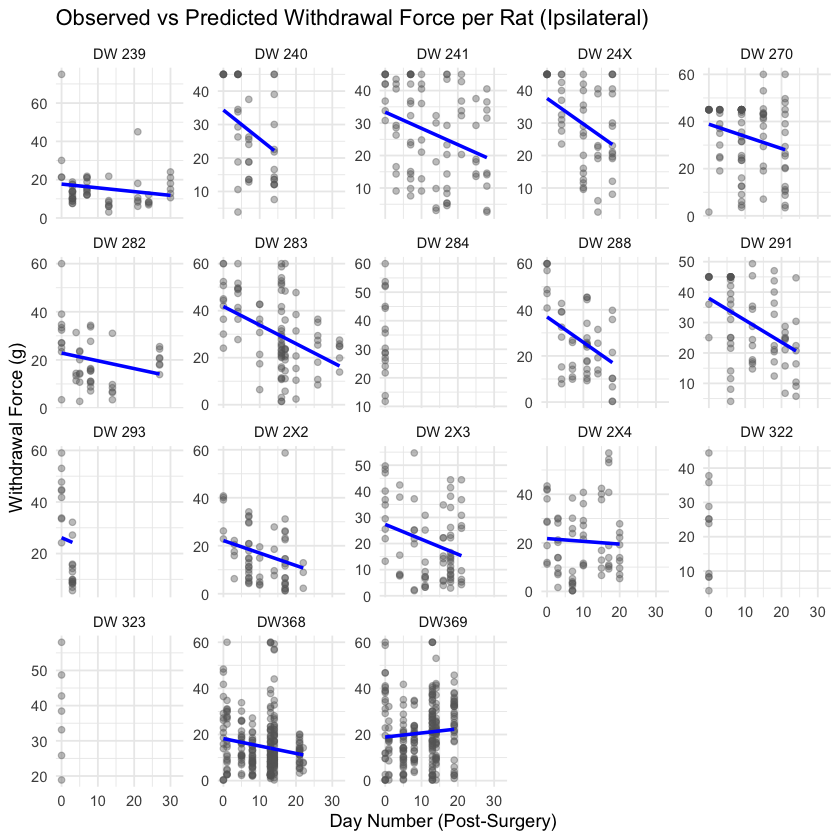

In [22]:
ggplot(vf_i, aes(x = DayNumber, y = Force)) +
  geom_point(alpha = 0.4, color = "grey40") +  # Observed data
  geom_line(aes(y = PredictedForce), color = "blue", linewidth = 1) +  # Model prediction
  facet_wrap(~ ID, scales = "free_y") +  # One panel per rat
  labs(
    title = "Observed vs Predicted Withdrawal Force per Rat (Ipsilateral)",
    x = "Day Number (Post-Surgery)",
    y = "Withdrawal Force (g)"
  ) +
  theme_minimal()

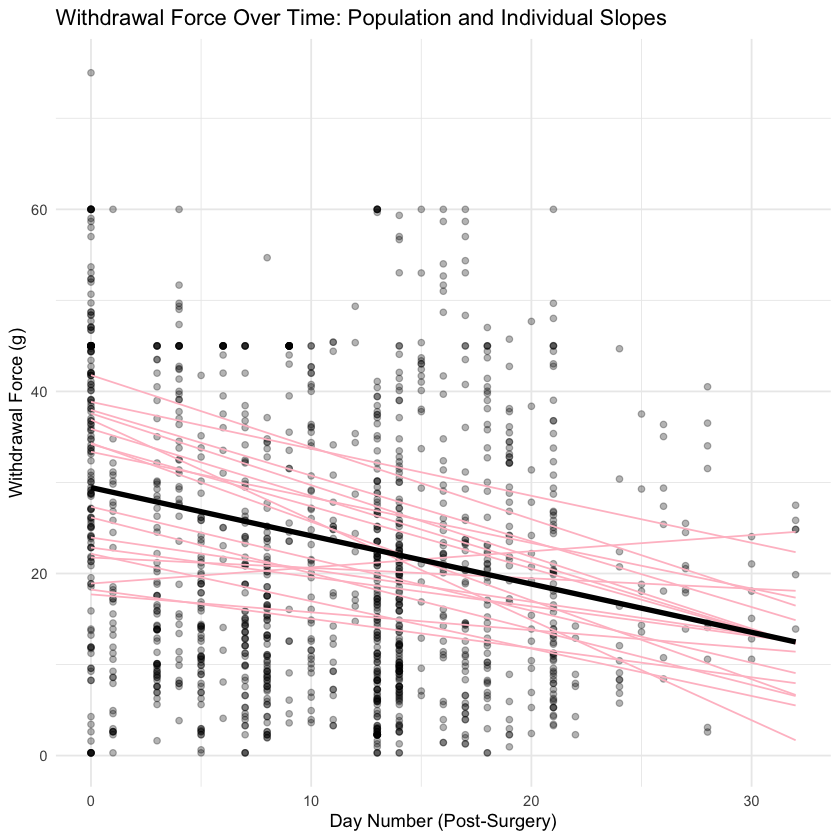

In [37]:

# Store mean and SD for back-transforming
day_mean = mean(vf_i$DayNumber, na.rm = TRUE)
day_sd   = sd(vf_i$DayNumber, na.rm = TRUE)

# Population-level prediction grid
newdata = data.frame(
  DayNumber_z = seq(min(vf_i$DayNumber_z), max(vf_i$DayNumber_z), length.out = 100)
)
newdata$DayNumber = newdata$DayNumber_z * day_sd + day_mean
newdata$pred_fixed = predict(m2_scaled, newdata, re.form = NA)

# Individual-level prediction grid (random slopes + intercepts)
ind_preds = vf_i %>%
  group_by(ID) %>%
  do({
    DayNumber_z_seq = seq(min(vf_i$DayNumber_z), max(vf_i$DayNumber_z), length.out = 100)
    data.frame(
      ID = unique(.$ID),
      DayNumber_z = DayNumber_z_seq,
      DayNumber = DayNumber_z_seq * day_sd + day_mean,
      pred = predict(m2_scaled, newdata = data.frame(
        DayNumber_z = DayNumber_z_seq,
        ID = unique(.$ID)
      ))
    )
  })

# Plot: population + individual lines + raw data
ggplot() +
  geom_point(data = vf_i, aes(x = DayNumber, y = Force), alpha = 0.3) +
  geom_line(data = ind_preds, aes(x = DayNumber, y = pred, group = ID), 
            color = "pink", alpha = 1.0) +
  geom_line(data = newdata, aes(x = DayNumber, y = pred_fixed), 
            color = "black", size = 1.5) +
  labs(
    title = "Withdrawal Force Over Time: Population and Individual Slopes",
    x = "Day Number (Post-Surgery)",
    y = "Withdrawal Force (g)"
  ) +
  theme_minimal()


In [39]:
head(vf)

Session Date                Treatment Protocol Stage DayNumber Trial ID    
1 1       2024-03-12 16:21:00 CCD       AMN      PRE   0         C     DW 239
2 2       2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
3 3       2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
4 4       2024-03-12 16:22:00 CCD       AMN      PRE   0         I     DW 239
5 5       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
6 6       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
  Latency Reason    Scoring Force
1 0.9     Detection Auto    33.81
2 0.1     Detection Auto     5.09
3 0.8     Detection Auto    31.31
4 0.5     Detection Auto    21.32
5 2.6     Detection Auto    75.00
6 0.5     Detection Auto    21.32

In [40]:
vf$Stage[vf$Stage=="POST1"] = "POST"

In [41]:
vf

Session Date                Treatment Protocol Stage DayNumber Trial
1     1      2024-03-12 16:21:00 CCD       AMN      PRE   0         C    
2     2      2024-03-12 16:22:00 CCD       AMN      PRE   0         C    
3     3      2024-03-12 16:22:00 CCD       AMN      PRE   0         C    
4     4      2024-03-12 16:22:00 CCD       AMN      PRE   0         I    
5     5      2024-03-12 16:23:00 CCD       AMN      PRE   0         I    
6     6      2024-03-12 16:23:00 CCD       AMN      PRE   0         I    
7     7      2024-03-12 16:24:00 CCD       AMN      PRE   0         I    
8     8      2024-03-15 16:46:00 CCD       AMN      POST  3         I    
9     9      2024-03-15 16:46:00 CCD       AMN      POST  3         I    
10   10      2024-03-15 16:46:00 CCD       AMN      POST  3         I    
11   11      2024-03-15 16:46:00 CCD       AMN      POST  3         I    
12   12      2024-03-15 16:47:00 CCD       AMN      POST  3         I    
13   13      2024-03-15 16:47:00 CCD       AMN      POST  3         I    
14   14      2024-03-15 16:47:00 CCD       AMN      POST  3         I    
15   15      2024-03-15 16:47:00 CCD       AMN      POST  3         I    
16   16      2024-03-15 16:49:00 CCD       AMN      POST  3         C    
17   17      2024-03-15 16:49:00 CCD       AMN      POST  3         C    
18   18      2024-03-15 16:50:00 CCD       AMN      POST  3         C    
19   19      2024-03-15 16:50:00 CCD       AMN      POST  3         C    
20   20      2024-03-15 16:50:00 CCD       AMN      POST  3         C    
21   21      2024-03-15 16:51:00 CCD       AMN      POST  3         I    
22   22      2024-03-15 16:51:00 CCD       AMN      POST  3         I    
23   23      2024-03-15 16:51:00 CCD       AMN      POST  3         I    
24   24      2024-03-15 16:51:00 CCD       AMN      POST  3         I    
25   25      2024-03-15 16:52:00 CCD       AMN      POST  3         C    
26   26      2024-03-15 16:53:00 CCD       AMN      POST  3         C    
27   27      2024-03-15 16:53:00 CCD       AMN      POST  3         C    
28   28      2024-03-15 16:53:00 CCD       AMN      POST  3         C    
29   29      2024-03-15 16:53:00 CCD       AMN      POST  3         C    
30   30      2024-03-15 16:53:00 CCD       AMN      POST  3         I    
⋮    ⋮       ⋮                   ⋮         ⋮        ⋮     ⋮         ⋮    
2408 3960    2025-07-24 09:24:49 CCD       AMN      POST  22        C    
2409 3961    2025-07-24 09:25:00 CCD       AMN      POST  22        C    
2410 3962    2025-07-24 09:25:13 CCD       AMN      POST  22        C    
2411 3963    2025-07-24 09:25:23 CCD       AMN      POST  22        C    
2412 3964    2025-07-24 09:25:37 CCD       AMN      POST  22        C    
2413 3965    2025-07-24 09:26:39 CCD       AMN      POST  22        C    
2414 3966    2025-07-24 09:26:58 CCD       AMN      POST  22        C    
2415 3967    2025-07-24 09:27:25 CCD       AMN      POST  22        C    
2416 3968    2025-07-24 09:27:41 CCD       AMN      POST  22        C    
2417 3969    2025-07-24 09:28:37 CCD       AMN      POST  22        C    
2418 3970    2025-07-24 09:28:49 CCD       AMN      POST  22        C    
2419 3971    2025-07-24 09:29:16 CCD       AMN      POST  22        C    
2420 3972    2025-07-24 09:29:26 CCD       AMN      POST  22        C    
2421 3973    2025-07-24 09:29:47 CCD       AMN      POST  22        C    
2422 3974    2025-07-24 09:29:57 CCD       AMN      POST  22        C    
2423 3975    2025-07-24 09:30:53 CCD       AMN      POST  22        C    
2424 3976    2025-07-24 09:31:31 CCD       AMN      POST  22        C    
2425 3977    2025-07-24 09:31:50 CCD       AMN      POST  22        C    
2426 3978    2025-07-24 09:32:14 CCD       AMN      POST  22        C    
2427 3979    2025-07-24 09:32:28 CCD       AMN      POST  22        C    
2428 3980    2025-07-24 09:32:45 CCD       AMN      POST  22        C    
2429 3981    2025-07-24 09:33:01 CCD       AMN      POST  22        C    
2430 3982

In [43]:
unique(vf$Stage)

[1] "PRE"  "POST" "TEST"

In [44]:
vf$Stage == 'TEST'

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [253] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [505] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [517] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [529] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [541] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [553] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [565] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [577] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [589] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [601] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALS

In [45]:
head(vf)

Session Date                Treatment Protocol Stage DayNumber Trial ID    
1 1       2024-03-12 16:21:00 CCD       AMN      PRE   0         C     DW 239
2 2       2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
3 3       2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
4 4       2024-03-12 16:22:00 CCD       AMN      PRE   0         I     DW 239
5 5       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
6 6       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
  Latency Reason    Scoring Force
1 0.9     Detection Auto    33.81
2 0.1     Detection Auto     5.09
3 0.8     Detection Auto    31.31
4 0.5     Detection Auto    21.32
5 2.6     Detection Auto    75.00
6 0.5     Detection Auto    21.32

In [46]:
vf$Stage[vf$Stage == 'TEST'] = 'POST'

In [47]:
unique(vf$Stage)

[1] "PRE"  "POST"

In [48]:
vf_i = subset(vf, Trial == 'I')

In [49]:
vf_c = subset (vf, Trial == 'C')

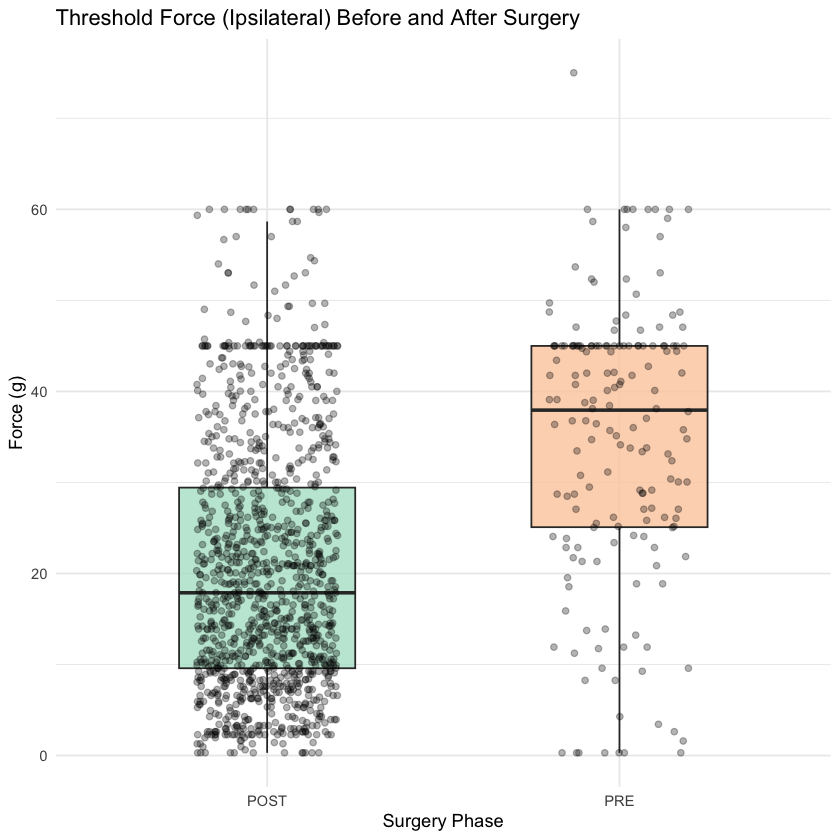

In [53]:
ggplot(vf_i,aes(x = Stage, y = Force, fill= Stage))+
      geom_boxplot(width = 0.5, alpha = 0.8, outlier.shape = NA)+ 
      geom_jitter(width = 0.2, alpha = 0.3, color = 'Black' )+ 
      labs (
          title = 'Threshold Force (Ipsilateral) Before and After Surgery', 
          x = 'Surgery Phase', 
          y = 'Force (g)'
      )+ 
theme_minimal() +
  scale_fill_brewer(palette = "Pastel2") +
  theme(legend.position = "none")

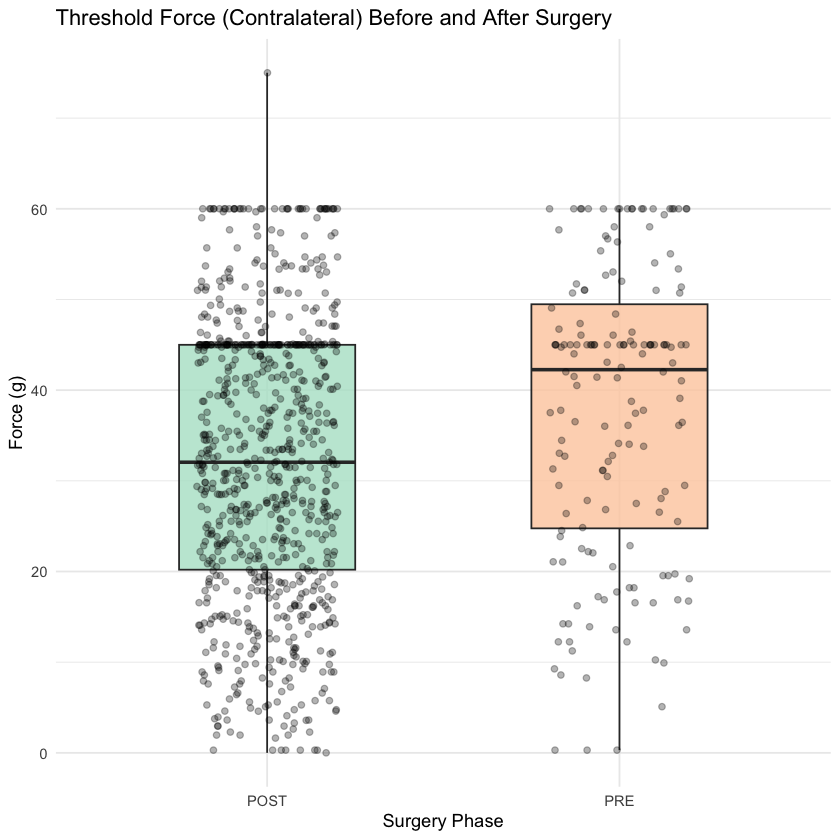

In [57]:
ggplot(vf_c,aes(x = Stage, y = Force, fill= Stage))+
      geom_boxplot(width = 0.5, alpha = 0.8, outlier.shape = NA)+ 
      geom_jitter(width = 0.2, alpha = 0.3, color = 'Black' )+ 
      labs (
          title = 'Threshold Force (Contralateral) Before and After Surgery', 
          x = 'Surgery Phase', 
          y = 'Force (g)'
      )+ 
theme_minimal() +
  scale_fill_brewer(palette = "Pastel2") +
  theme(legend.position = "none")

In [58]:
model_i = lmer(Force ~ DayNumber + (DayNumber | ID) , data = vf_i)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.464711 (tol = 0.002, component 1)”


In [62]:
# standardizing daynumber 
vf_i$DayNumber_z = scale(vf_i$DayNumber)

In [63]:
model_i_scaled = lmer(Force ~ DayNumber_z + (DayNumber_z | ID) ,
                      data = vf_i, 
                      control = lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e5))
                     )

In [64]:
summary(model_i_scaled)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber_z + (DayNumber_z | ID)
   Data: vf_i
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

REML criterion at convergence: 10809.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9005 -0.7151 -0.1037  0.6782  4.4602 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  38.615   6.214        
          DayNumber_z   7.124   2.669   -0.40
 Residual             165.015  12.846        
Number of obs: 1353, groups:  ID, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept)  23.8400     1.5651  15.232
DayNumber_z  -3.8288     0.7795  -4.912

Correlation of Fixed Effects:
            (Intr)
DayNumber_z -0.226

# observations 
- on an average, the withdrawal force is 23.84 g at the mean day (DayNumber_z = 0)
- force decreases by 3.83g per 1SD increase in days post surgery
- random effect correlation: -0.40
      - rats that start at a higher baseline force decline more steeply over time in terms of their threshold force

In [65]:
# standardizing daynumber 
vf_c$DayNumber_z = scale(vf_c$DayNumber) 

In [68]:
model_c_scaled = lmer (Force ~ DayNumber_z + (DayNumber | ID), 
                       data = vf_c, 
                       control = lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e5))
                       )

In [69]:
summary(model_c_scaled)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber_z + (DayNumber | ID)
   Data: vf_c
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

REML criterion at convergence: 8222.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.48143 -0.77459  0.07085  0.64921  2.62685 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 ID       (Intercept)  55.82107  7.4713       
          DayNumber     0.08889  0.2981  -0.84
 Residual             214.69990 14.6526       
Number of obs: 997, groups:  ID, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept)  33.2765     1.3212  25.186
DayNumber_z  -1.7645     0.7757  -2.275

Correlation of Fixed Effects:
            (Intr)
DayNumber_z -0.329

# observations 
- scaled residuals are in the normal range of being centered around 0 with +- 2
- force decreases by 1.7g per 1SD increase in days post surgery

In [71]:
ggplot(vf, aes(x = DayNumber_z, y = Force, color = Trial)) +
  # Individual rat trajectories
  geom_line(aes(group = interaction(ID, Trial)), alpha = 0.3) +
  
  # Population-level slope
  geom_smooth(aes(group = Side), method = "lm", size = 2, se = TRUE) +
  
  labs(
    title = "Individual and Population Slopes of Withdrawal Force",
    x = "Standardized Days Post Surgery",
    y = "Force (g)",
    color = "Side"
  ) +
  theme_minimal()

ERROR while rich displaying an object: Error in `geom_line()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'DayNumber_z' not found

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr))

In [72]:
vf$DayNumber_z = scale(vf$DayNumber)

`geom_smooth()` using formula = 'y ~ x'


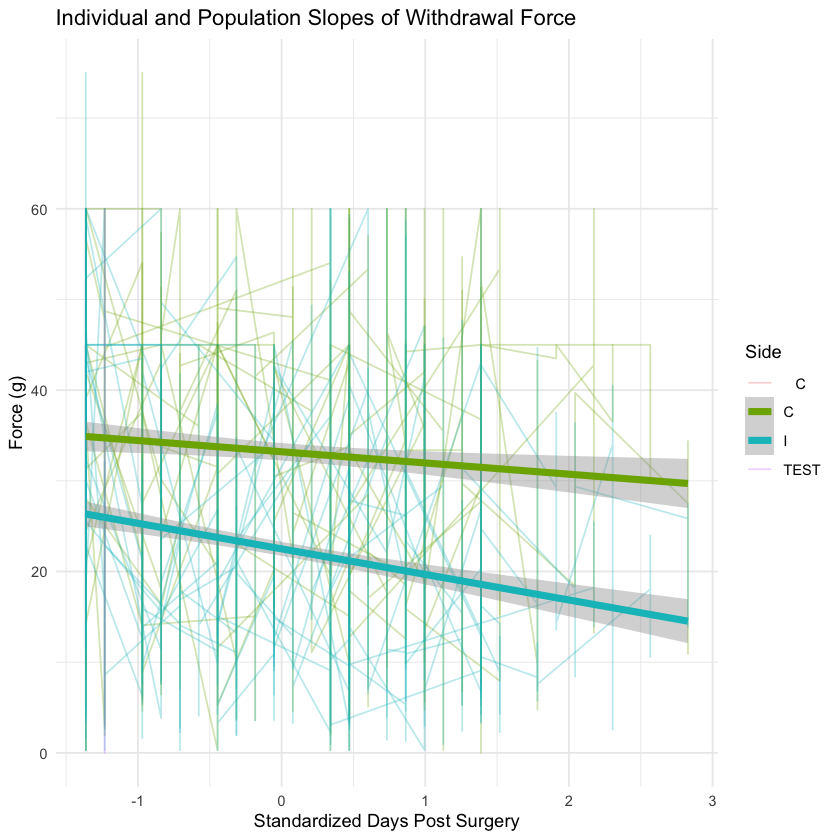

In [74]:
ggplot(vf, aes(x = DayNumber_z, y = Force, color = Trial)) +
  # Individual rat trajectories
  geom_line(aes(group = interaction(ID, Trial)), alpha = 0.3) +
  
  # Population-level slope
  geom_smooth(aes(group = Trial), method = "lm", size = 2, se = TRUE) +
  
  labs(
    title = "Individual and Population Slopes of Withdrawal Force",
    x = "Standardized Days Post Surgery",
    y = "Force (g)",
    color = "Side"
  ) +
  theme_minimal()

In [75]:
unique(vf$Trial)

[1] "C"    "I"    "   C" "TEST"

In [77]:
vf$Trial[vf$Trial == '   C'] = 'C'

In [78]:
unique(vf$Trial)

[1] "C"    "I"    "TEST"

In [79]:
vf = vf %>%
filter( Trial != 'TEST')

In [80]:
unique(vf$Trial)

[1] "C" "I"

`geom_smooth()` using formula = 'y ~ x'


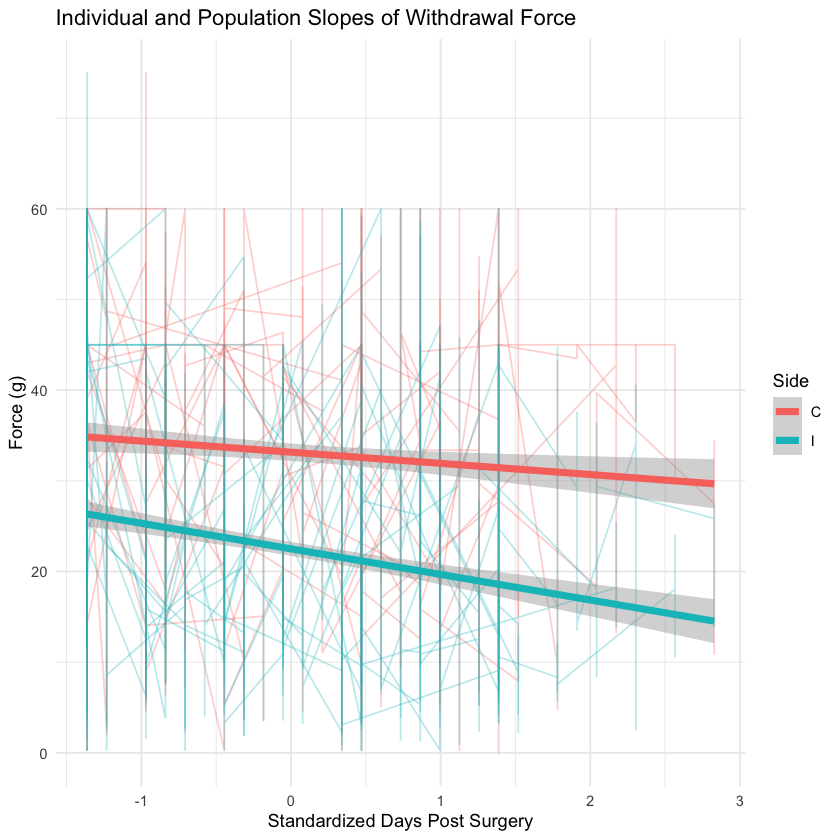

In [81]:
ggplot(vf, aes(x = DayNumber_z, y = Force, color = Trial)) +
  # Individual rat trajectories
  geom_line(aes(group = interaction(ID, Trial)), alpha = 0.3) +
  
  # Population-level slope
  geom_smooth(aes(group = Trial), method = "lm", size = 2, se = TRUE) +
  
  labs(
    title = "Individual and Population Slopes of Withdrawal Force",
    x = "Standardized Days Post Surgery",
    y = "Force (g)",
    color = "Side"
  ) +
  theme_minimal()

`geom_smooth()` using formula = 'y ~ x'


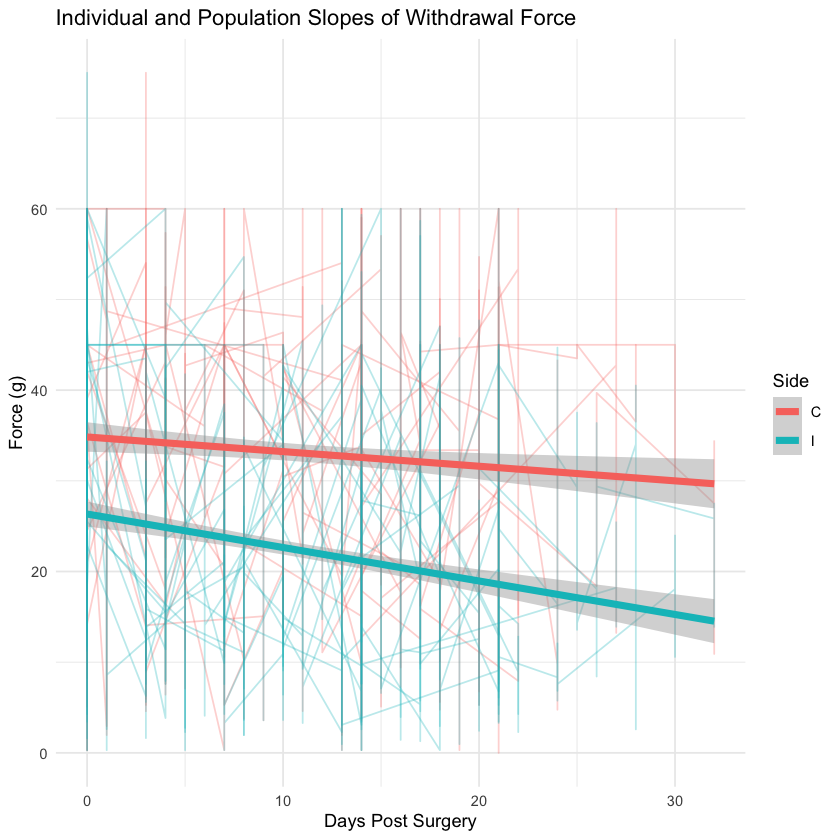

In [82]:
ggplot(vf, aes(x = DayNumber, y = Force, color = Trial)) +
  # Individual rat trajectories
  geom_line(aes(group = interaction(ID, Trial)), alpha = 0.3) +
  
  # Population-level slope
  geom_smooth(aes(group = Trial), method = "lm", size = 2, se = TRUE) +
  
  labs(
    title = "Individual and Population Slopes of Withdrawal Force",
    x = "Days Post Surgery",
    y = "Force (g)",
    color = "Side"
  ) +
  theme_minimal()

`geom_smooth()` using formula = 'y ~ x'


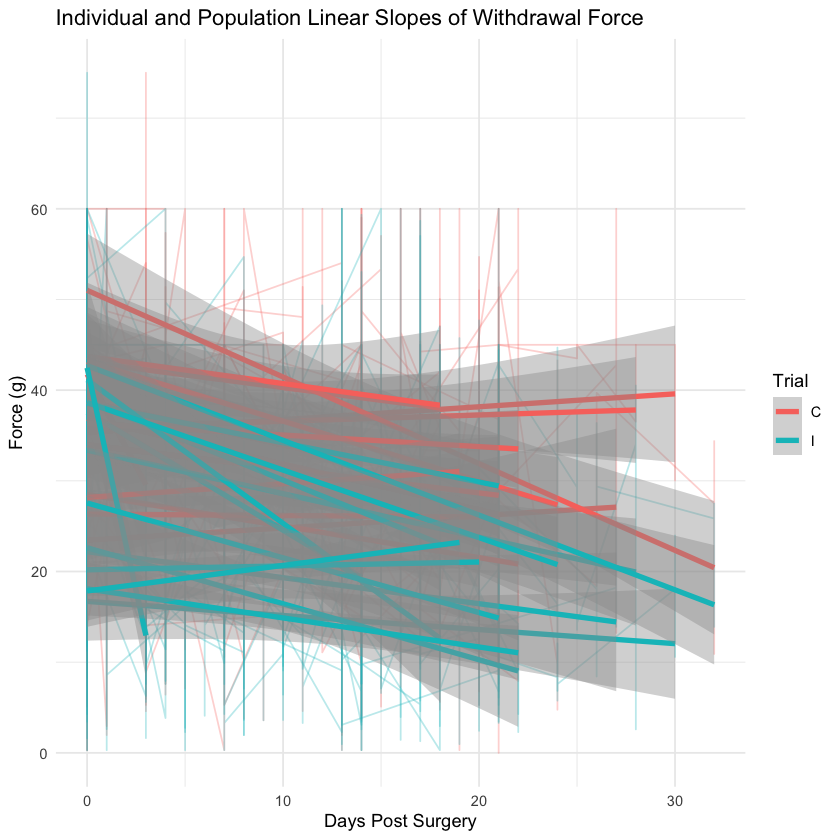

In [88]:
ggplot(vf, aes(x = DayNumber, y = Force, group = interaction(ID, Trial), color = Trial)) +
  geom_line(alpha = 0.3) +
  stat_smooth(data = vf, aes(x = DayNumber, y = Force, color = Trial), 
              method = "lm", se = TRUE, size = 1.5) +
  labs(
    title = "Individual and Population Linear Slopes of Withdrawal Force",
    x = "Days Post Surgery",
    y = "Force (g)"
  ) +
  theme_minimal()

In [89]:
new_model = lmer(Force ~ DayNumber * Trial + (DayNumber |ID), data = vf)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0800121 (tol = 0.002, component 1)”


In [90]:
# getting model predictions for daynumber per side 

pred = ggpredict(new_model, terms = c('DayNumber', 'Trial'))

In [107]:
#getting random effects per ID 
rand_eff = ranef(new_model)$ID %>% 
  tibble::rownames_to_column("ID") %>%
  rename(intercept = `(Intercept)`, slope = DayNumber)

fixef_df = fixef(new_model) # intercept + slope (population)
rand_eff = rand_eff %>%
  mutate(
    intercept = fixef_df[1] + intercept,
    slope = fixef_df[2] + slope
  )

vf_fits = vf %>%
  left_join(rand_eff, by = "ID") %>%
  mutate(.fitted = intercept + slope * DayNumber)

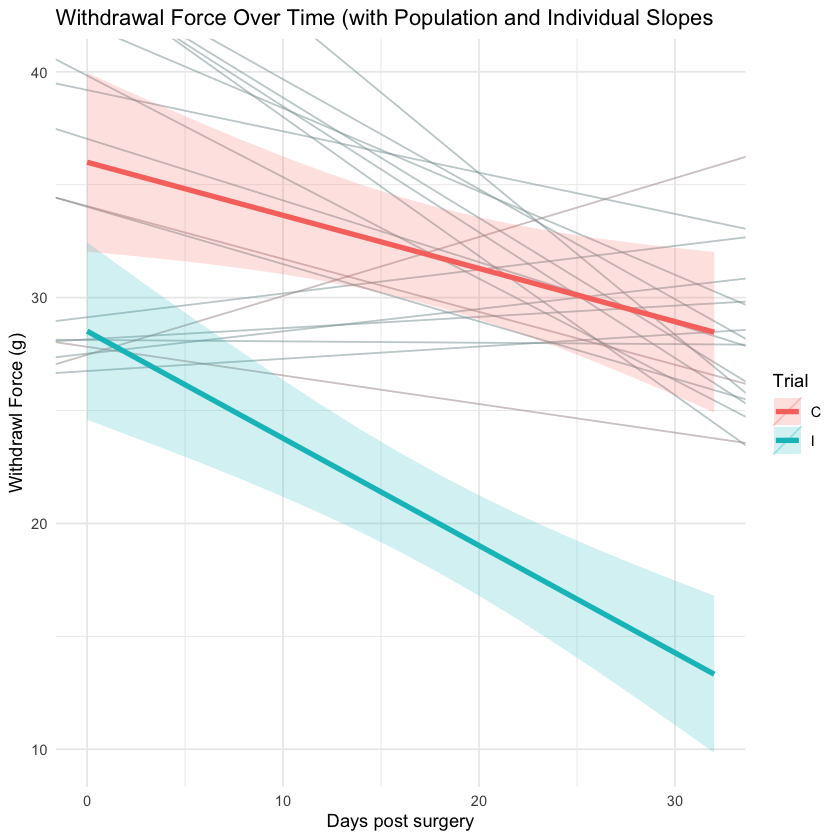

In [108]:
ggplot()+ 
geom_abline(data = vf_fits, 
            aes(intercept = intercept, slope = slope, color = Trial), 
            alpha = 0.3, 
)+ 
geom_line (
    data = pred, 
    aes(x = x, y = predicted, color = group), 
    linewidth = 1.5
)+ 
geom_ribbon(
    data = pred, 
    aes(x = x, ymin = conf.low, ymax = conf.high, fill = group),
    alpha = 0.2,
    inherit.aes = FALSE
) + 
labs (
    title = 'Withdrawal Force Over Time (with Population and Individual Slopes', 
    x = 'Days post surgery', 
    y = 'Withdrawl Force (g)',
    color = 'Trial', 
    fill = 'Trial'
)+ 
theme_minimal()

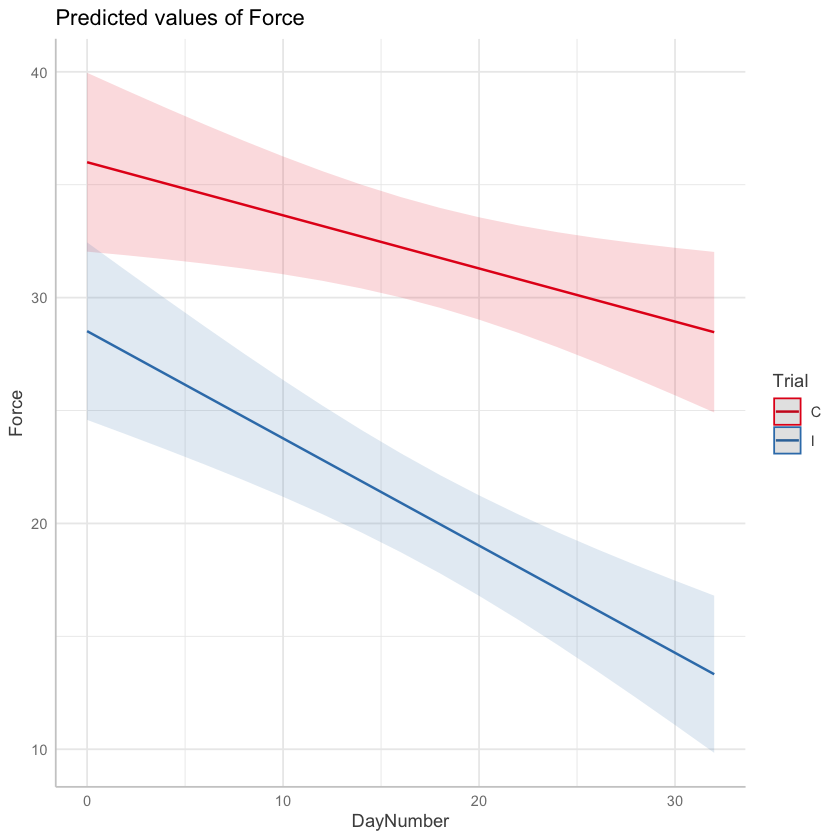

In [96]:
pred =ggpredict(new_model, terms = c("DayNumber", "Trial"))
plot(pred)

In [99]:
# comparing two models 
m1 = lmer (Force ~ DayNumber_z + (DayNumber_z| ID), data = vf)
m2 = lmer (Force ~ DayNumber_z * Trial + (DayNumber_z |ID), data = vf)

In [100]:
anova(m1, m2)

refitting model(s) with ML (instead of REML)



npar AIC      BIC      logLik    -2*log(L) Chisq    Df Pr(>Chisq)  
m1 6    19479.51 19514.10 -9733.755 19467.51        NA NA           NA
m2 8    19199.42 19245.55 -9591.711 19183.42  284.0891  2 2.045683e-62

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0800121 (tol = 0.002, component 1)”


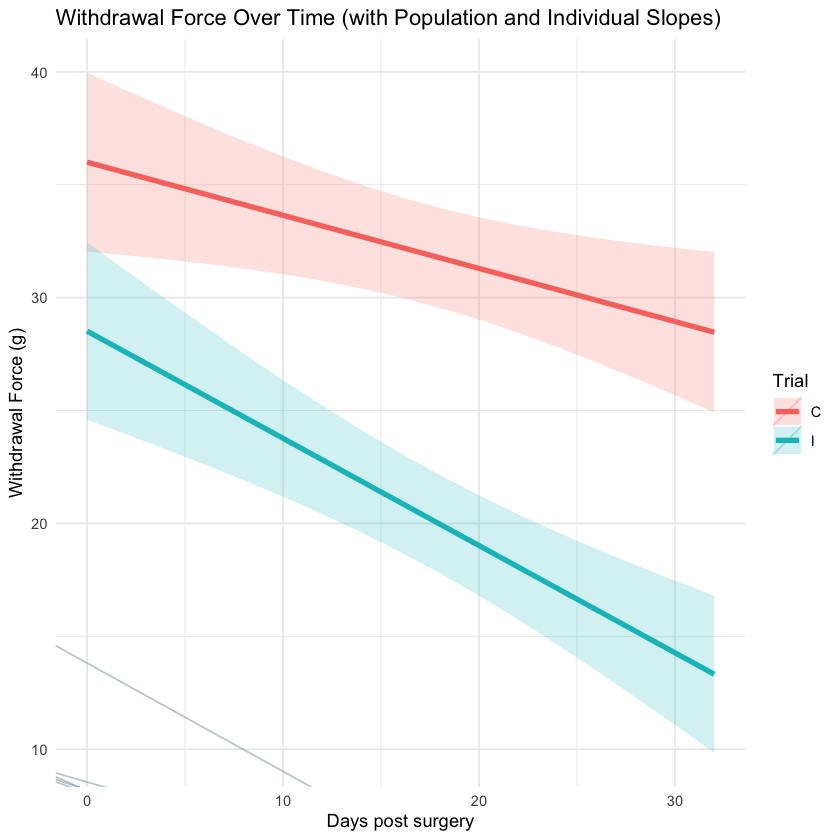

In [103]:
model <- lmer(Force ~ DayNumber * Trial + (DayNumber | ID), data = vf)

# Extract population-level predictions
pred <- ggpredict(model, terms = c("DayNumber", "Trial"))

# Extract individual random slopes
rand_eff <- ranef(model)$ID %>%
  tibble::rownames_to_column("ID") %>%
  rename(intercept = `(Intercept)`, slope = DayNumber)

# Merge with Trial info
rand_eff <- rand_eff %>%
  left_join(vf %>% select(ID, Trial) %>% distinct(), by = "ID")

# Plot
ggplot() +
  # Individual lines
  geom_abline(data = rand_eff, aes(intercept = intercept, slope = slope, color = Trial), alpha = 0.3) +
  # Population slopes
  geom_line(data = pred, aes(x = x, y = predicted, color = group), size = 1.5) +
  geom_ribbon(data = pred, aes(x = x, ymin = conf.low, ymax = conf.high, fill = group), alpha = 0.2) +
  labs(title = "Withdrawal Force Over Time (with Population and Individual Slopes)",
       x = "Days post surgery", y = "Withdrawal Force (g)", color = "Trial", fill = "Trial") +
  theme_minimal()

In [109]:
unique(vf$Trial)

[1] "C" "I"

In [112]:
vf_i = vf_i %>% 
group_by(ID, Stage) %>%
summarise(MeanForce = mean(Force, na.rm = TRUE), .groups = "drop")

In [113]:
t_ipsi = t.test(
  MeanForce ~ Stage,
  data = vf_i,
  paired = TRUE
)

ERROR: Error in t.test.formula(MeanForce ~ Stage, data = vf_i, paired = TRUE): cannot use 'paired' in formula method


In [114]:
# converting data to wide format so that the PRE and POST values are in separate columns so we can perform paired T test 
vf_i_wide = tidyr::pivot_wider(
  vf_i,
  names_from = Stage,
  values_from = MeanForce
)

ERROR: Error in loadNamespace(x): there is no package called ‘tidyr’


In [115]:
install.packages('tidyr')

also installing the dependencies ‘stringi’, ‘purrr’, ‘stringr’, ‘cpp11’





The downloaded binary packages are in
	/var/folders/ws/dmbkn8cx75l33lp2zph5rpbw0000gn/T//Rtmp8xg5S0/downloaded_packages


In [116]:
library(tidyr)


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [117]:
# converting data to wide format so that the PRE and POST values are in separate columns so we can perform paired T test 
vf_i_wide = tidyr::pivot_wider(
  vf_i,
  names_from = Stage,
  values_from = MeanForce
)

In [118]:
head(vf_i_wide)

ID     POST     PRE     
1 DW 239 13.27755 36.92500
2 DW 240 25.09371 45.00000
3 DW 241 25.57833 40.59444
4 DW 24X 27.59191 45.00000
5 DW 270 33.27177 39.57500
6 DW 282 16.51556 30.55000

In [120]:
#peforming paired t test 
t_ipsi = t.test(
  vf_i_wide$PRE,
  vf_i_wide$POST,
  paired = TRUE
)

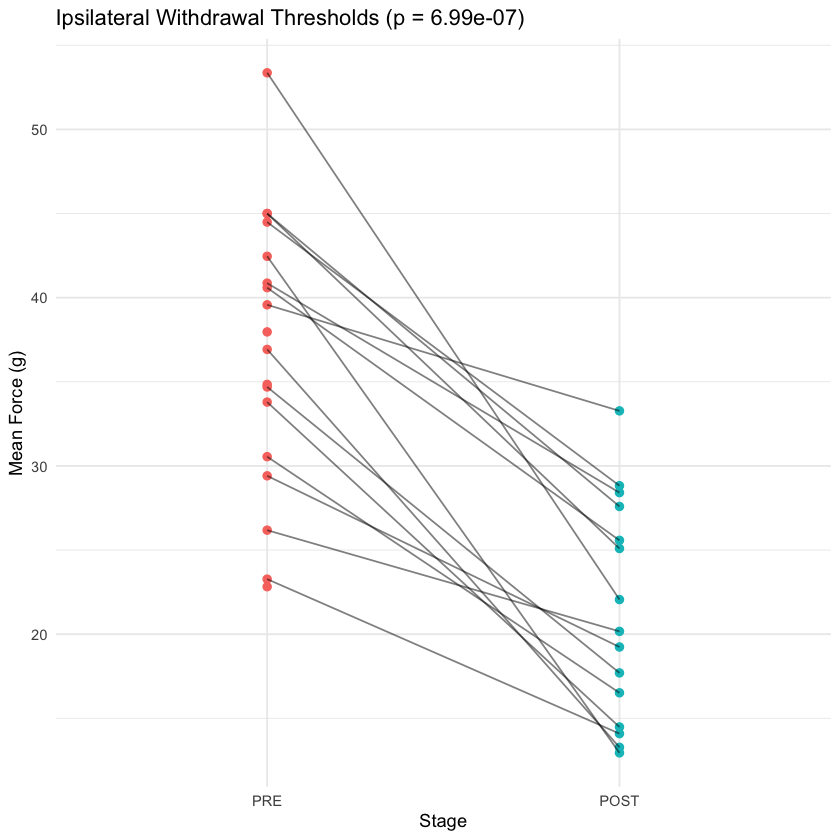

In [142]:
#spaghetti plot per rat pre and post 
ggplot( vf_i, aes(x = Stage, y = MeanForce, group = ID))+ 
geom_point(aes(color = Stage), size = 2) +
  geom_line(alpha = 0.5) +
  theme_minimal() +
  labs(
    title = paste0(
      "Ipsilateral Withdrawal Thresholds (p = ",
      signif(t_ipsi$p.value, 3), ")"
    ),
    y = "Mean Force (g)"
  ) +
  theme(legend.position = "none")

In [122]:
head(vf_i)

ID     Stage MeanForce
1 DW 239 POST  13.27755 
2 DW 239 PRE   36.92500 
3 DW 240 POST  25.09371 
4 DW 240 PRE   45.00000 
5 DW 241 POST  25.57833 
6 DW 241 PRE   40.59444

In [123]:
head(vf_c)

Session Date                Treatment Protocol Stage DayNumber Trial ID    
1   1      2024-03-12 16:21:00 CCD       AMN      PRE   0         C     DW 239
2   2      2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
3   3      2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
16 16      2024-03-15 16:49:00 CCD       AMN      POST  3         C     DW 239
17 17      2024-03-15 16:49:00 CCD       AMN      POST  3         C     DW 239
18 18      2024-03-15 16:50:00 CCD       AMN      POST  3         C     DW 239
   Latency Reason        Scoring Force DayNumber_z
1   0.9    Detection     Auto    33.81 -1.3616708 
2   0.1    Detection     Auto     5.09 -1.3616708 
3   0.8    Detection     Auto    31.31 -1.3616708 
16  1.0    Detection     Auto    37.55 -0.9878175 
17  1.4    Detection     Auto    53.78 -0.9878175 
18 18.0    Screen Button Auto    75.00 -0.9878175

In [125]:
t_ipsi$p.value

[1] 6.986958e-07

In [126]:
t_ipsi$statistic

t 
8.47159

In [127]:
t_ipsi$estimate

mean difference 
       16.46171

In [134]:
vf_i$Stage = factor (vf_i$Stage, levels = c('PRE', 'POST'))

In [135]:
levels(vf_i$Stage)

[1] "PRE"  "POST"

In [138]:
t.test(
    MeanForce ~ Stage, 
    data = vf_i, 
    paired = TRUE
)

ERROR: Error in t.test.formula(MeanForce ~ Stage, data = vf_i, paired = TRUE): cannot use 'paired' in formula method


In [139]:
head(vf_i)

ID     Stage MeanForce
1 DW 239 POST  13.27755 
2 DW 239 PRE   36.92500 
3 DW 240 POST  25.09371 
4 DW 240 PRE   45.00000 
5 DW 241 POST  25.57833 
6 DW 241 PRE   40.59444

In [140]:
vf_i_wide = vf_i %>%
  pivot_wider(names_from = Stage, values_from = MeanForce)

In [141]:
t.test(
    vf_i_wide$POST, 
    vf_i_wide$PRE, 
    paired = TRUE
)


	Paired t-test

data:  vf_i_wide$POST and vf_i_wide$PRE
t = -8.4716, df = 14, p-value = 6.987e-07
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -20.62939 -12.29404
sample estimates:
mean difference 
      -16.46171 


# Paired T test results PRE and POST (Ipsilateral)
- p value significantly smaller than 0.05 which successfully rejects the null hypothesis meaning that there is a statistically significant difference between pre and post force threshold values on the ipsilateral side 
- confidence interval does not include 0
- mean difference points to a 6.46 g decrease in force threshold 

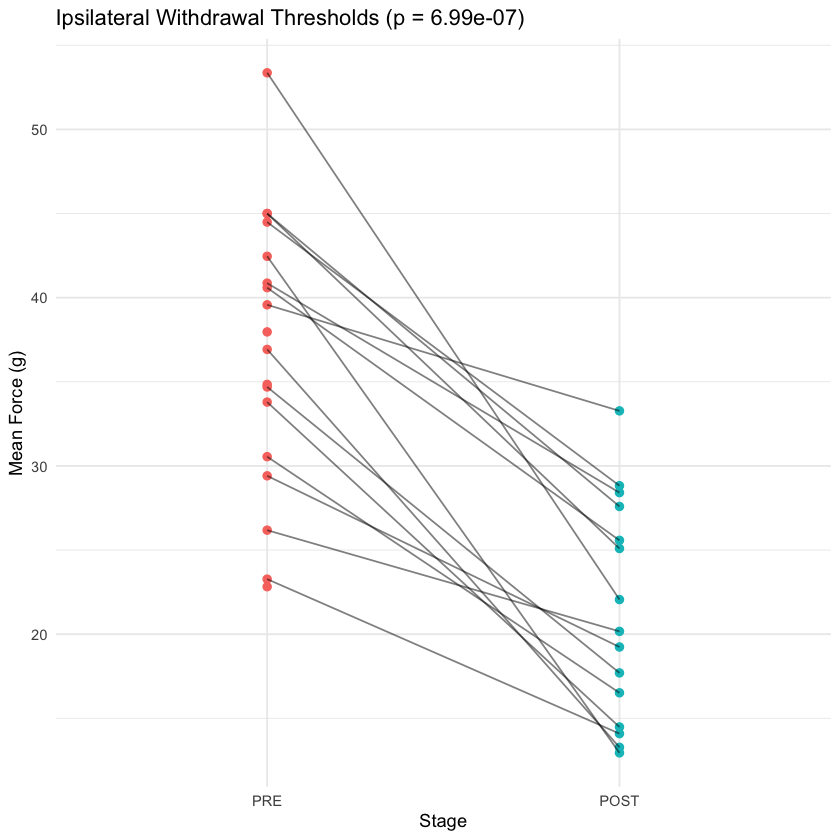

In [144]:
#spaghetti plot PRE and POST (ipsilateral)
ggplot( vf_i, aes(x = Stage, y = MeanForce, group = ID))+ 
geom_point(aes(color = Stage), size = 2) +
  geom_line(alpha = 0.5) +
  theme_minimal() +
  labs(
    title = paste0(
      "Ipsilateral Withdrawal Thresholds (p = ",
      signif(t_ipsi$p.value, 3), ")"
    ),
    y = "Mean Force (g)"
  ) +
  theme(legend.position = "none")

In [146]:
head(vf_c)

Session Date                Treatment Protocol Stage DayNumber Trial ID    
1   1      2024-03-12 16:21:00 CCD       AMN      PRE   0         C     DW 239
2   2      2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
3   3      2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
16 16      2024-03-15 16:49:00 CCD       AMN      POST  3         C     DW 239
17 17      2024-03-15 16:49:00 CCD       AMN      POST  3         C     DW 239
18 18      2024-03-15 16:50:00 CCD       AMN      POST  3         C     DW 239
   Latency Reason        Scoring Force DayNumber_z
1   0.9    Detection     Auto    33.81 -1.3616708 
2   0.1    Detection     Auto     5.09 -1.3616708 
3   0.8    Detection     Auto    31.31 -1.3616708 
16  1.0    Detection     Auto    37.55 -0.9878175 
17  1.4    Detection     Auto    53.78 -0.9878175 
18 18.0    Screen Button Auto    75.00 -0.9878175

In [149]:
vf_c_small = vf_c %>% 
group_by(ID, Stage) %>%
summarise(MeanForce = mean(Force, na.rm = TRUE), .groups = "drop")

In [150]:
head(vf_c_small)

ID     Stage MeanForce
1 DW 239 POST  38.24721 
2 DW 239 PRE   23.40333 
3 DW 240 POST  33.15739 
4 DW 240 PRE   44.40200 
5 DW 241 POST  36.20481 
6 DW 241 PRE   41.15143

In [155]:
vf_c_small$Stage = factor (vf_c_small$Stage, levels = c('PRE', 'POST'))

In [156]:
levels(vf_c_small$Stage)

[1] "PRE"  "POST"

In [158]:
vf_c_wide = vf_c_small %>% 
pivot_wider (names_from = Stage, values_from = MeanForce)

In [160]:
t_contra = t.test(
    vf_c_wide$POST, 
    vf_c_wide$PRE, 
    paired = TRUE
)

In [161]:
t_contra


	Paired t-test

data:  vf_c_wide$POST and vf_c_wide$PRE
t = -2.9559, df = 14, p-value = 0.01042
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -12.52498  -1.99171
sample estimates:
mean difference 
      -7.258343 


# paired T test PRE and POST (contralateral)
- p vaue statistically insignificant ---- no statistically significant difference in pre and post force thresholds for the contralateral side 

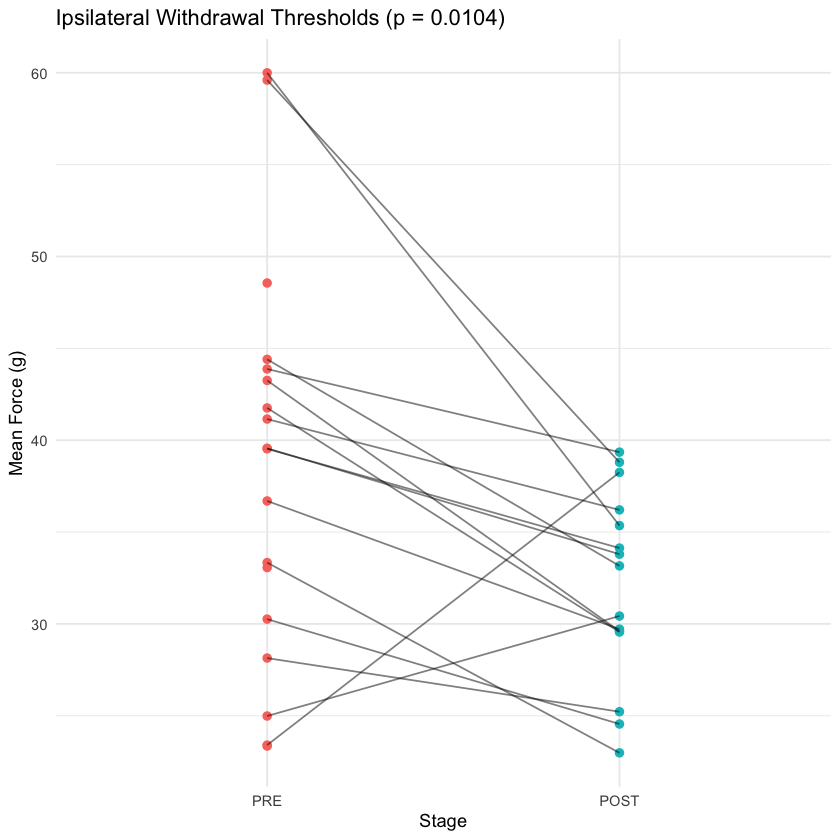

In [162]:
#spaghetti plot PRE and POST (contralateral)
ggplot( vf_c_small, aes(x = Stage, y = MeanForce, group = ID))+ 
geom_point(aes(color = Stage), size = 2) +
  geom_line(alpha = 0.5) +
  theme_minimal() +
  labs(
    title = paste0(
      "Ipsilateral Withdrawal Thresholds (p = ",
      signif(t_contra$p.value, 3), ")"
    ),
    y = "Mean Force (g)"
  ) +
  theme(legend.position = "none")

In [163]:
head(vf)

Session Date                Treatment Protocol Stage DayNumber Trial ID    
1 1       2024-03-12 16:21:00 CCD       AMN      PRE   0         C     DW 239
2 2       2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
3 3       2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
4 4       2024-03-12 16:22:00 CCD       AMN      PRE   0         I     DW 239
5 5       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
6 6       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
  Latency Reason    Scoring Force DayNumber_z
1 0.9     Detection Auto    33.81 -1.362636  
2 0.1     Detection Auto     5.09 -1.362636  
3 0.8     Detection Auto    31.31 -1.362636  
4 0.5     Detection Auto    21.32 -1.362636  
5 2.6     Detection Auto    75.00 -1.362636  
6 0.5     Detection Auto    21.32 -1.362636

In [164]:
vf_i = subset(vf, Trial == 'I')

In [165]:
head(vf_i)

Session Date                Treatment Protocol Stage DayNumber Trial ID    
4 4       2024-03-12 16:22:00 CCD       AMN      PRE   0         I     DW 239
5 5       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
6 6       2024-03-12 16:23:00 CCD       AMN      PRE   0         I     DW 239
7 7       2024-03-12 16:24:00 CCD       AMN      PRE   0         I     DW 239
8 8       2024-03-15 16:46:00 CCD       AMN      POST  3         I     DW 239
9 9       2024-03-15 16:46:00 CCD       AMN      POST  3         I     DW 239
  Latency Reason    Scoring Force DayNumber_z
4 0.5     Detection Auto    21.32 -1.3626357 
5 2.6     Detection Auto    75.00 -1.3626357 
6 0.5     Detection Auto    21.32 -1.3626357 
7 0.8     Detection Auto    30.06 -1.3626357 
8 0.3     Detection Auto    12.58 -0.9696949 
9 0.2     Detection Auto    10.09 -0.9696949

In [166]:
head(vf_c)

Session Date                Treatment Protocol Stage DayNumber Trial ID    
1   1      2024-03-12 16:21:00 CCD       AMN      PRE   0         C     DW 239
2   2      2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
3   3      2024-03-12 16:22:00 CCD       AMN      PRE   0         C     DW 239
16 16      2024-03-15 16:49:00 CCD       AMN      POST  3         C     DW 239
17 17      2024-03-15 16:49:00 CCD       AMN      POST  3         C     DW 239
18 18      2024-03-15 16:50:00 CCD       AMN      POST  3         C     DW 239
   Latency Reason        Scoring Force DayNumber_z
1   0.9    Detection     Auto    33.81 -1.3616708 
2   0.1    Detection     Auto     5.09 -1.3616708 
3   0.8    Detection     Auto    31.31 -1.3616708 
16  1.0    Detection     Auto    37.55 -0.9878175 
17  1.4    Detection     Auto    53.78 -0.9878175 
18 18.0    Screen Button Auto    75.00 -0.9878175

In [171]:
# comparing lmer models 
m1 = lmer (Force ~ DayNumber_z + (DayNumber_z| ID), data = vf)
m2 = lmer (Force ~ DayNumber_z * Trial + (DayNumber_z| ID), data = vf)

In [172]:
anova(m1,m2)

refitting model(s) with ML (instead of REML)



npar AIC      BIC      logLik    -2*log(L) Chisq    Df Pr(>Chisq)  
m1 6    19479.51 19514.10 -9733.755 19467.51        NA NA           NA
m2 8    19199.42 19245.55 -9591.711 19183.42  284.0891  2 2.045683e-62

In [173]:
summary(m2)

Linear mixed model fit by REML ['lmerMod']
Formula: Force ~ DayNumber_z * Trial + (DayNumber_z | ID)
   Data: vf

REML criterion at convergence: 19179

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6076 -0.7496 -0.0673  0.6920  3.8242 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept)  26.616   5.159        
          DayNumber_z   6.013   2.452   -0.75
 Residual             194.662  13.952        
Number of obs: 2358, groups:  ID, 18

Fixed effects:
                   Estimate Std. Error t value
(Intercept)         33.5491     1.3155  25.503
DayNumber_z         -1.7967     0.7414  -2.423
TrialI              -9.9732     0.5914 -16.865
DayNumber_z:TrialI  -1.8293     0.5858  -3.123

Correlation of Fixed Effects:
            (Intr) DyNmb_ TrialI
DayNumber_z -0.514              
TrialI      -0.244  0.028       
DyNmbr_z:TI  0.013 -0.412 -0.060

# observations
- TrialI = -9.97
      - on an average day, the ipsilateral side is about 10g lower in force threshold than the contralateral side
- DayNumber_z = -1.79
      - each 1SD day observes a decrease of 1.8 g in the threshold force on the ipsilateral side
- variance in intercept = 26.616 and residual = 194
      - great variability within the population which is accounted for by the (DayNumber_z|ID) term 

In [176]:
# extract mean and SD to backtransform standardized day number to actual day number 
day_mean = mean(vf$DayNumber, na.rm = TRUE)
day_sd = sd(vf$DayNumber, na.rm = FALSE)

In [177]:
# get model predictions for both sides 
pred = ggpredict(m2, terms = c('DayNumber_z', 'Trial'))

In [178]:
head(pred)

x    predicted std.error conf.low conf.high group
1 -1.5 36.24422  2.114558  32.09763 40.39081  C    
2 -1.5 29.01494  2.098337  24.90015 33.12972  I    
3 -1.0 35.34585  1.811879  31.79280 38.89890  C    
4 -1.0 27.20191  1.798478  23.67515 30.72868  I    
5 -0.5 34.44748  1.539250  31.42905 37.46591  C    
6 -0.5 25.38889  1.527617  22.39327 28.38451  I

In [181]:
# convert standardized day to day 
pred$DayNumber = pred$x * day_sd + day_mean

In [182]:
head(pred)

x    predicted std.error conf.low conf.high group DayNumber 
1 -1.5 36.24422  2.114558  32.09763 40.39081  C     -0.6242033
2 -1.5 29.01494  2.098337  24.90015 33.12972  I     -0.6242033
3 -1.0 35.34585  1.811879  31.79280 38.89890  C      3.1566663
4 -1.0 27.20191  1.798478  23.67515 30.72868  I      3.1566663
5 -0.5 34.44748  1.539250  31.42905 37.46591  C      6.9375359
6 -0.5 25.38889  1.527617  22.39327 28.38451  I      6.9375359

In [195]:
indiv_lines <- vf %>%
  group_by(ID, Trial) %>%
  do({
    mod <- lm(Force ~ DayNumber, data = .)
    data.frame(
      DayNumber = seq(min(.$DayNumber), max(.$DayNumber), length.out = 2),  # just endpoints
      Force = predict(mod, newdata = data.frame(DayNumber = seq(min(.$DayNumber), max(.$DayNumber), length.out = 2)))
    )
  })

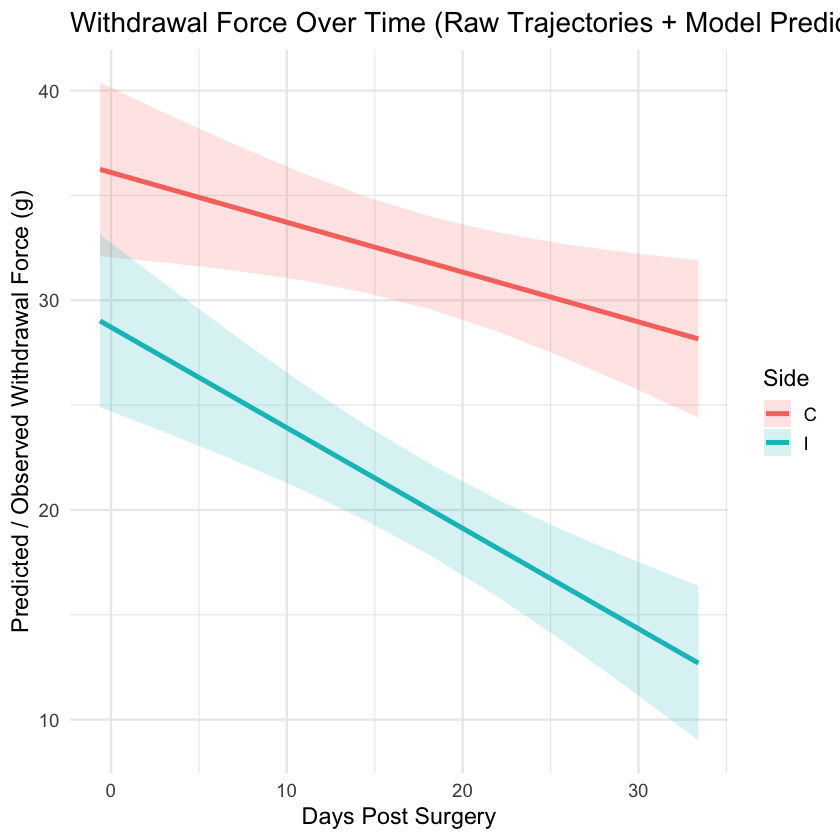

In [198]:
ggplot() +
  # Population CI ribbons
  geom_ribbon(
    data = pred,
    aes(x = DayNumber, ymin = conf.low, ymax = conf.high, fill = group),
    alpha = 0.18, color = NA
  ) +
  # Population lines
  geom_line(
    data = pred,
    aes(x = DayNumber, y = predicted, color = group),
    linewidth = 1.4
  ) +
  labs(
    title = "Withdrawal Force Over Time (Raw Trajectories + Model Predictions)",
    x = "Days Post Surgery",
    y = "Predicted / Observed Withdrawal Force (g)",
    color = "Side",
    fill  = "Side"
  ) +
  theme_minimal(base_size = 14)

In [200]:
# Build an ID × Trial prediction grid and get lines
ind_preds <- vf %>%
  distinct(ID, Trial) %>%                 # one row per rat per side
  group_by(ID, Trial) %>%
  do({
    DayNumber_z_seq <- seq(min(vf$DayNumber_z, na.rm = TRUE),
                           max(vf$DayNumber_z, na.rm = TRUE),
                           length.out = 100)
    data.frame(
      ID = .$ID[1],
      Trial = .$Trial[1],
      DayNumber_z = DayNumber_z_seq,
      DayNumber   = DayNumber_z_seq * day_sd + day_mean,
      pred = predict(
        m2,
        newdata = data.frame(
          DayNumber_z = DayNumber_z_seq,
          ID = .$ID[1],
          Trial = .$Trial[1]              # <- key fix: include Trial
        )
        # re.form = NULL includes random effects by default
      )
    )
  }) %>%
  ungroup()

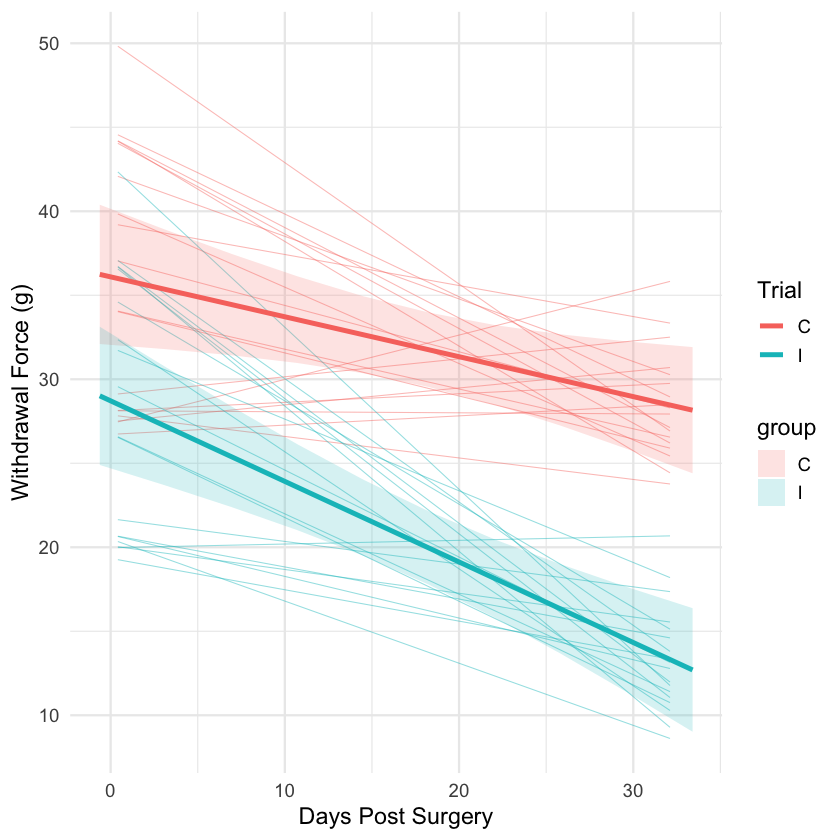

In [202]:
ggplot() +
  geom_line(data = ind_preds,
            aes(x = DayNumber, y = pred,
                group = interaction(ID, Trial), color = Trial),
            alpha = 0.45, linewidth = 0.3) +
# Population CI ribbons
  geom_ribbon(
    data = pred,
    aes(x = DayNumber, ymin = conf.low, ymax = conf.high, fill = group),
    alpha = 0.18, color = NA
  ) +
  # Population lines
  geom_line(
    data = pred,
    aes(x = DayNumber, y = predicted, color = group),
    linewidth = 1.4
  ) +
  labs(x = "Days Post Surgery", y = "Withdrawal Force (g)")+
  theme_minimal(base_size = 14)


In [208]:
perday = vf%>%
filter(Trial %in% c('I' ,'C')) %>% 
group_by(Trial, DayNumber) %>% 
summarise (
    n=n(), 
    sd = sd(Force, na.rm = TRUE), 
    mean = mean(Force, na.rm =TRUE), 
    sem = sd/sqrt(n),
    .groups= 'drop'
)

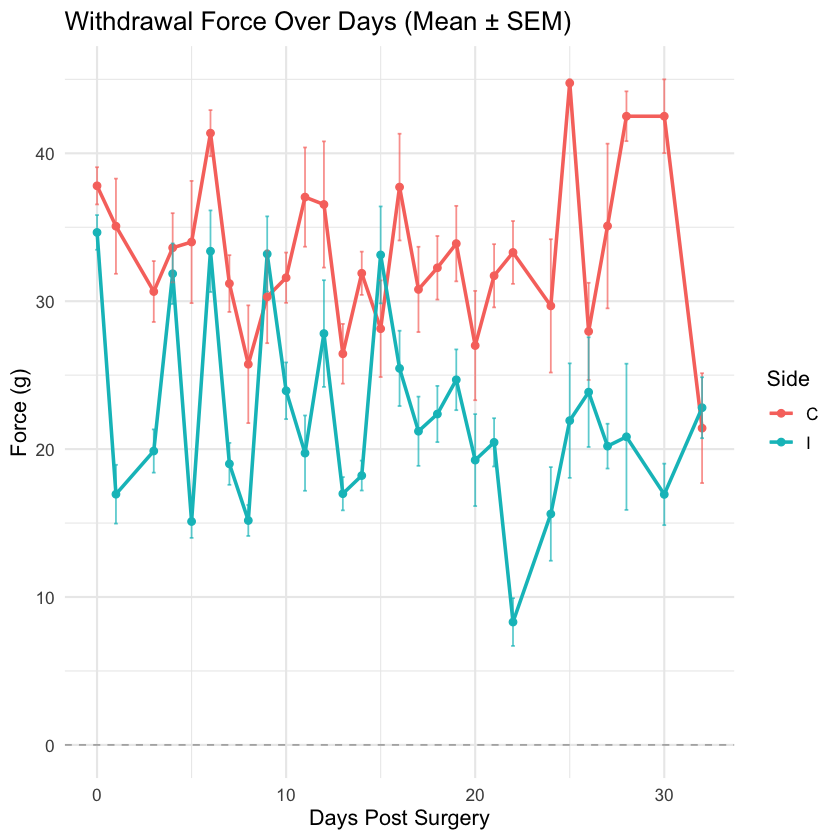

In [210]:
# Mean ± SEM line plot
ggplot(perday, aes(x = DayNumber, y = mean, color = Trial, group = Trial)) +
  geom_line(linewidth = 1) +
  geom_point(size = 1.8) +
  geom_errorbar(aes(ymin = mean - sem, ymax = mean + sem), width = 0.2, alpha = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.3) +
  labs(
    title = "Withdrawal Force Over Days (Mean ± SEM)",
    x = "Days Post Surgery",
    y = "Force (g)",
    color = "Side"
  ) +
  theme_minimal(base_size = 13)

`geom_smooth()` using formula = 'y ~ x'


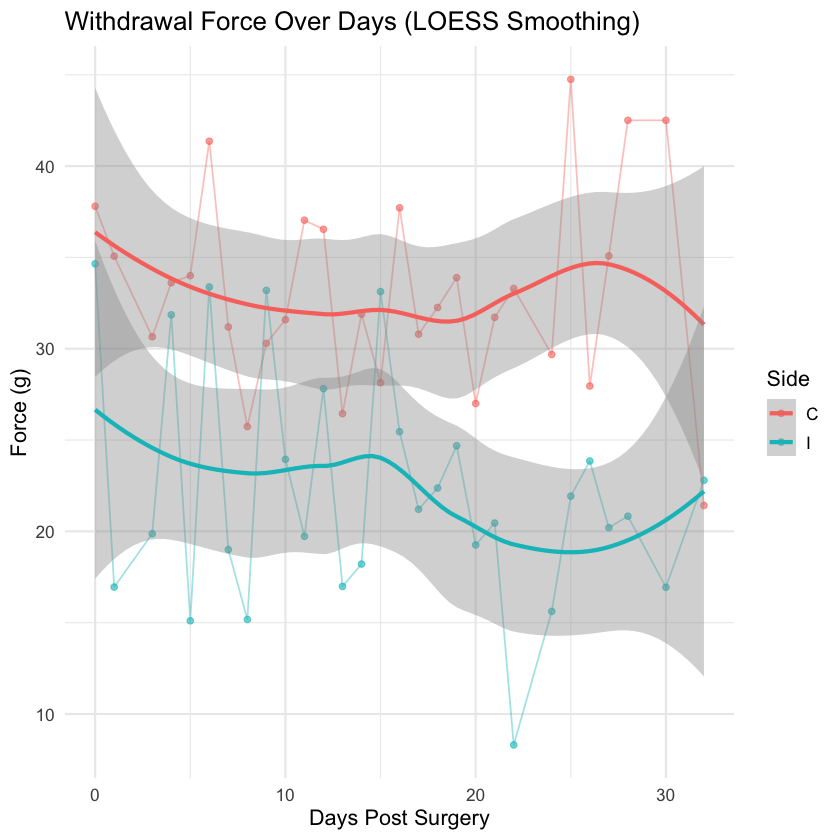

In [211]:
ggplot(perday, aes(x = DayNumber, y = mean, color = Trial, group = Trial)) +
  geom_line(alpha = 0.4) +  # faint raw lines
  geom_point(size = 1.5, alpha = 0.6) +
  geom_smooth(method = "loess", se = TRUE, linewidth = 1.2) +
  labs(
    title = "Withdrawal Force Over Days (LOESS Smoothing)",
    x = "Days Post Surgery",
    y = "Force (g)",
    color = "Side"
  ) +
  theme_minimal(base_size = 13)


In [212]:
# Collapse to per-rat-per-day means for each side
by_rat_day <- vf %>%
  filter(Trial %in% c("I","C")) %>%
  group_by(ID, Trial, DayNumber) %>%
  summarise(MeanForce = mean(Force, na.rm = TRUE), .groups = "drop")

# Wide: columns I and C, then difference (I − C)
wide_diff <- by_rat_day %>%
  pivot_wider(names_from = Trial, values_from = MeanForce) %>%
  mutate(Diff_I_minus_C = I - C)
 

In [213]:
ggplot(wide_diff, aes(x = DayNumber, y = Diff_I_minus_C, group = ID)) +
  geom_line(alpha = 0.35, color = "gray40") +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(
    title = "Side Difference Over Time (Ipsilateral − Contralateral)",
    x = "Days Post Surgery",
    y = "Difference in Force (g)"
  ) +
  theme_minimal(base_size = 13)


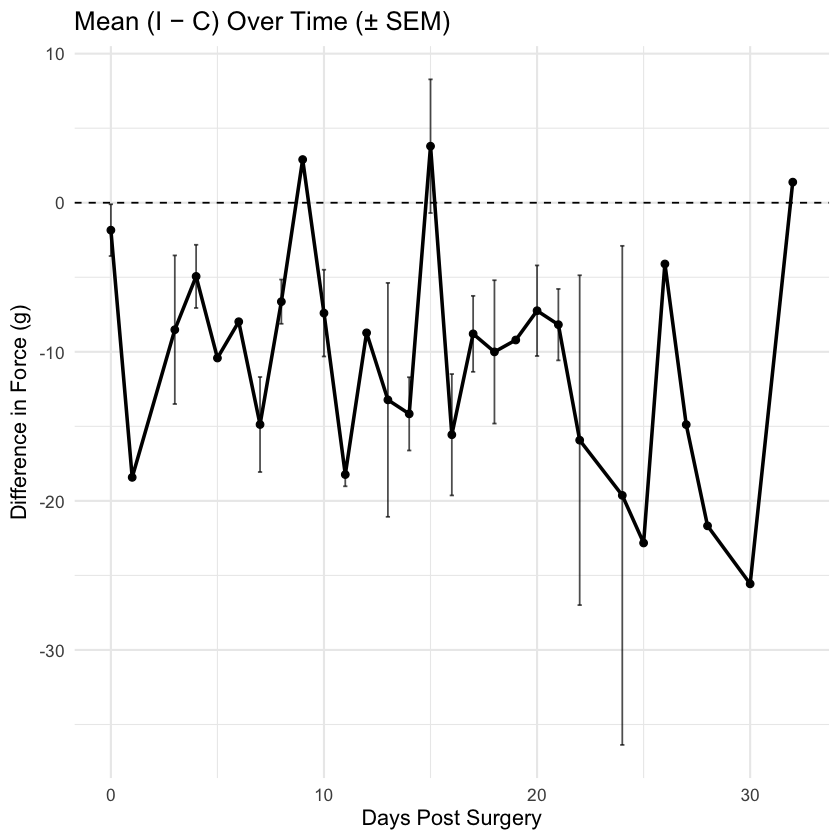

In [214]:
diff_summary <- wide_diff %>%
  group_by(DayNumber) %>%
  summarise(
    n   = n(),
    mean = mean(Diff_I_minus_C, na.rm = TRUE),
    sd   = sd(Diff_I_minus_C,   na.rm = TRUE),
    sem  = sd/sqrt(n),
    .groups = "drop"
  )

ggplot(diff_summary, aes(x = DayNumber, y = mean)) +
  geom_line(color = "black", linewidth = 1) +
  geom_point(color = "black", size = 1.8) +
  geom_errorbar(aes(ymin = mean - sem, ymax = mean + sem), width = 0.2, alpha = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(
    title = "Mean (I − C) Over Time (± SEM)",
    x = "Days Post Surgery",
    y = "Difference in Force (g)"
  ) +
  theme_minimal(base_size = 13)
